<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('../ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import sklearn
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
%matplotlib inline

# Task 1: 
create a table with 3 columns: day, employee_headcount, company_id

In [3]:
dat = pd.read_csv("employee_retention_data.csv", ).infer_objects()
dat.join_date = pd.to_datetime(dat.join_date, infer_datetime_format=True)
dat.quit_date = pd.to_datetime(dat.quit_date, infer_datetime_format=True)
# dat.astype({'join_date': })
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
dat_join = dat.groupby(['join_date', 'company_id']).size().reset_index()
dat_join.columns = ['join_date','company_id','join_count']
dat_quit = dat.groupby(['quit_date', 'company_id']).size().reset_index()
dat_quit.columns = ['quit_date','company_id','quit_count']

In [5]:
ts = pd.date_range('24/01/2011','13/12/2015')
unique_dates = pd.DataFrame({'date':ts})

company_id = pd.unique(dat.company_id)
unique_companies = pd.DataFrame({'company_id':company_id})

unique_dates['key'] = 0
unique_companies['key'] = 0

blank = unique_dates.merge(unique_companies,how='right',on='key')
blank.drop('key',1, inplace=True)

In [6]:
'''
company_list=dat.company_id.unique().tolist()
company_list=sorted(company_list)
date_list = pd.date_range('24/01/2011', '13/12/2015')
blank = pd.MultiIndex.from_product([company_list, date_list],
                                  names = ['company_id', 'date']).to_frame()
'''
# another way to construct the blank, using multiindex from_product
pass

In [7]:
dat_join_update = pd.merge(blank, dat_join, left_on = ['company_id', 'date'],
                          right_on = ['company_id', 'join_date'],
                          how = 'left', sort = True)
dat_quit_update = pd.merge(dat_join_update, dat_quit, left_on = ['company_id', 'date'],
                          right_on = ['company_id', 'quit_date'],
                          how = 'left', sort = True)

In [8]:
dat_reduced = dat_quit_update[['date', 'company_id', 'join_count', 'quit_count']].fillna(0)
dat_reduced.head()

,date,company_id,join_count,quit_count
0,2011-01-24,1,25.0,0.0
1,2011-01-25,1,2.0,0.0
2,2011-01-26,1,2.0,0.0
3,2011-01-27,1,0.0,0.0
4,2011-01-28,1,0.0,0.0


In [9]:
dat_reduced['join_cum'] = dat_reduced.join_count.cumsum(axis = 0)
dat_reduced['quit_cum'] = dat_reduced.quit_count.cumsum(axis = 0)
dat_reduced['employee_headcount'] = dat_reduced.join_cum - dat_reduced.quit_cum
dat_reduced = dat_reduced[['date', 'company_id', 'employee_headcount']]

In [10]:
dat_reduced.head(5)

,date,company_id,employee_headcount
0,2011-01-24,1,25.0
1,2011-01-25,1,27.0
2,2011-01-26,1,29.0
3,2011-01-27,1,29.0
4,2011-01-28,1,29.0


In [11]:
if os.path.isfile('dat_reduced.csv'):
    print('data reduced csv file already exists, refer to root folder')
else:
    dat_reduced.to_csv("dat_reduced.csv", header = True, index = False)

data reduced csv file already exists, refer to root folder


# Task 2: 
what are the main factors that drive employee churn? Do they make sense? Explain your indings

In [12]:
dat.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Data Cleaning

{'whiskers': [<matplotlib.lines.Line2D at 0x19bfc696b38>,
 'caps': [<matplotlib.lines.Line2D at 0x19bfc69f438>,
 'boxes': [<matplotlib.lines.Line2D at 0x19bfc6969e8>],
 'medians': [<matplotlib.lines.Line2D at 0x19bfc69fc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x19bfc6a70f0>],
 'means': []}

<Figure size 720x432 with 0 Axes>

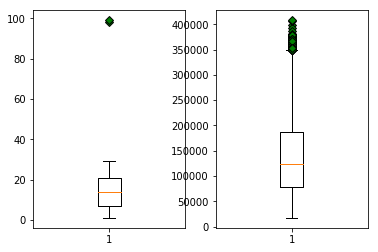

In [13]:
green_diamond = dict(markerfacecolor='g', marker='D')
plt.figure(figsize = (10, 6))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.boxplot(dat['seniority'], flierprops=green_diamond)
ax2.boxplot(dat['salary'], flierprops=green_diamond)

I think it s not appropriate to expect the seniors to continue to contribute to the company much longer. They should enjoy their life.

In [14]:
# clean the unreasonable seniority
dat = dat[dat['seniority'] <= 40]
# I believe the Pareto theory
# high_sal_dat = dat[dat['salary'] > dat.salary.quantile(0.80)]

## Feature Engineering

### Time related feature

In [15]:
# Add label with quit as 1 and 0 as stay and calculate working length
dat['onboard'] = dat['quit_date'].apply(lambda x: 0 if pd.isnull(x) else 1) # assign 0 to employee who doesn't quit 1 to quit
dat['quit_date'] = dat['quit_date'].apply(lambda x: pd.to_datetime('2015-12-13') if pd.isnull(x) else x) # assign the last day to NaN
dat['working_len'] = dat['quit_date'].apply(lambda x: pd.to_datetime(x)) - dat['join_date'].apply(lambda x: pd.to_datetime(x))
dat['working_len'] = dat['working_len'].apply(lambda x: int(x.days/30))
dat['quit_date'] = dat['quit_date'].apply(lambda x: None if x == pd.to_datetime('2015-12-13') else x)
dat['quit_month'] = dat['quit_date'].apply(lambda x: x.month)
dat['join_month'] = dat['join_date'].apply(lambda x: x.month)
dat['join_wdy'] = dat['join_date'].dt.dayofweek
dat['quit_wdy'] = dat['quit_date'].dt.dayofweek
dat.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,onboard,working_len,quit_month,join_month,join_wdy,quit_wdy
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,19,10.0,3,0,4.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,11,4.0,4,0,4.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,14,NaN,10,0,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,12,6.0,5,0,4.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,34,8.0,10,0,4.0


### Continuous feature

c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


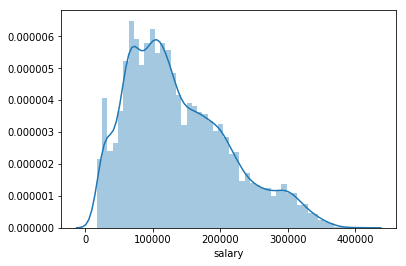

In [16]:
sns.distplot(dat['salary'])

In [17]:
seniority_bins = [1, 2, 5, 10, 15, 20, 25, 30]
dat['seniority_cut'] = pd.cut(dat['seniority'], seniority_bins)

In [18]:
dat.seniority_cut.value_counts()

(5, 10]     4757
(10, 15]    4637
(15, 20]    4455
(20, 25]    3789
(2, 5]      2712
(25, 30]    2547
(1, 2]       942
Name: seniority_cut, dtype: int64

In [19]:
salary_bins = [50000,100000,150000,200000,300000,410000]
group_names = ['low', 'medium_low', 'medium', 'medium_high','high']
dat['salary_cut'] = pd.cut(dat['salary'], salary_bins, labels=group_names)

In [20]:
dat.salary_cut.value_counts()

low            6788
medium_low     6191
medium         4303
medium_high    4149
high            946
Name: salary_cut, dtype: int64

In [21]:
worklen_bins = [6, 12, 18, 24, 30]
group_names = ['halfyear', 'oneyear', '1.5years', '2years']
dat['worklen_cut'] = pd.cut(dat['working_len'], worklen_bins, labels=group_names)
dat.worklen_cut.value_counts()

halfyear    7900
1.5years    3694
oneyear     3360
2years      2525
Name: worklen_cut, dtype: int64

### Get more familiar with the dat

In [22]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24700 entries, 0 to 24699
Data columns (total 16 columns):
employee_id      24700 non-null float64
company_id       24700 non-null int64
dept             24700 non-null object
seniority        24700 non-null int64
salary           24700 non-null float64
join_date        24700 non-null datetime64[ns]
quit_date        13508 non-null datetime64[ns]
onboard          24700 non-null int64
working_len      24700 non-null int64
quit_month       13508 non-null float64
join_month       24700 non-null int64
join_wdy         24700 non-null int64
quit_wdy         13508 non-null float64
seniority_cut    23839 non-null category
salary_cut       22377 non-null category
worklen_cut      17479 non-null category
dtypes: category(3), datetime64[ns](2), float64(4), int64(6), object(1)
memory usage: 2.7+ MB


Text(0.5,1,'pairplot of the employee features')

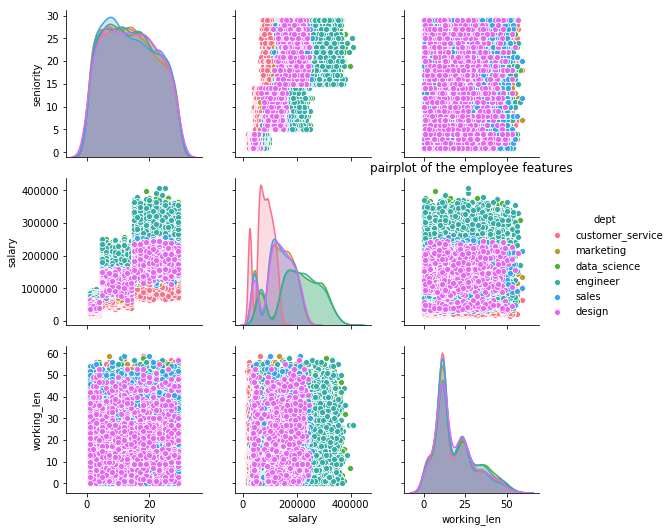

In [23]:
sns.pairplot(dat, hue='dept', vars=['seniority', 'salary', 'working_len'], palette="husl")
plt.title('pairplot of the employee features')
# plt.savefig(r"/ouput/pairplot_of_the_employee_features.png")

## Machine Learning Models

In [24]:
categorical_cols = list(dat.select_dtypes(include = ['object', 'category']).columns)
numerical_cols = list(dat.select_dtypes(include = ['int64']).columns)
numerical_cols.remove('onboard')
# numerical_cols = numerical_cols[numerical_cols != 'onboard']
Y = dat.onboard

In [25]:
def transform_categorical(dat, categorical_cols): 
    df_new = dat[categorical_cols]
    return( pd.get_dummies(df_new) )
datX_categorical = transform_categorical(dat, categorical_cols)

In [26]:
train_feature = []
totalValidRow = [True] * len(Y)
print('Selected Features:')
for feature in numerical_cols:
    validIndex = pd.notnull(dat[feature])
    # select feature with specific percent of valid rows 
    if len(validIndex[validIndex == True]) < 0.4*len(validIndex):
        continue
    totalValidRow = totalValidRow & validIndex[:len(totalValidRow)]
    train_feature.append(feature)
    print(feature)
print('Number of selected numerical features:', len(train_feature))
print('Total rows to be chosen:', sum(totalValidRow))
datX_numerical = dat[train_feature][totalValidRow.values]
datX_categorical = datX_categorical[totalValidRow.values]
Y = Y[totalValidRow.values]

Selected Features:
company_id
seniority
working_len
join_month
join_wdy
Number of selected numerical features: 5
Total rows to be chosen: 24700


In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = False)
scaler.fit(datX_numerical)
datX_numerical_scaled = scaler.transform(datX_numerical)
datX_numerical_scaled = pd.DataFrame(datX_numerical_scaled, columns = datX_numerical.columns)
datX_combined = pd.concat([datX_numerical_scaled, datX_categorical], axis = 1)

c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [54]:
import time
start_time = time.time()

# Import Decision Tree Modeler from sklearn
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6
)
decision_tree.fit(datX_combined, Y)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007984399795532227 seconds ---


In [55]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

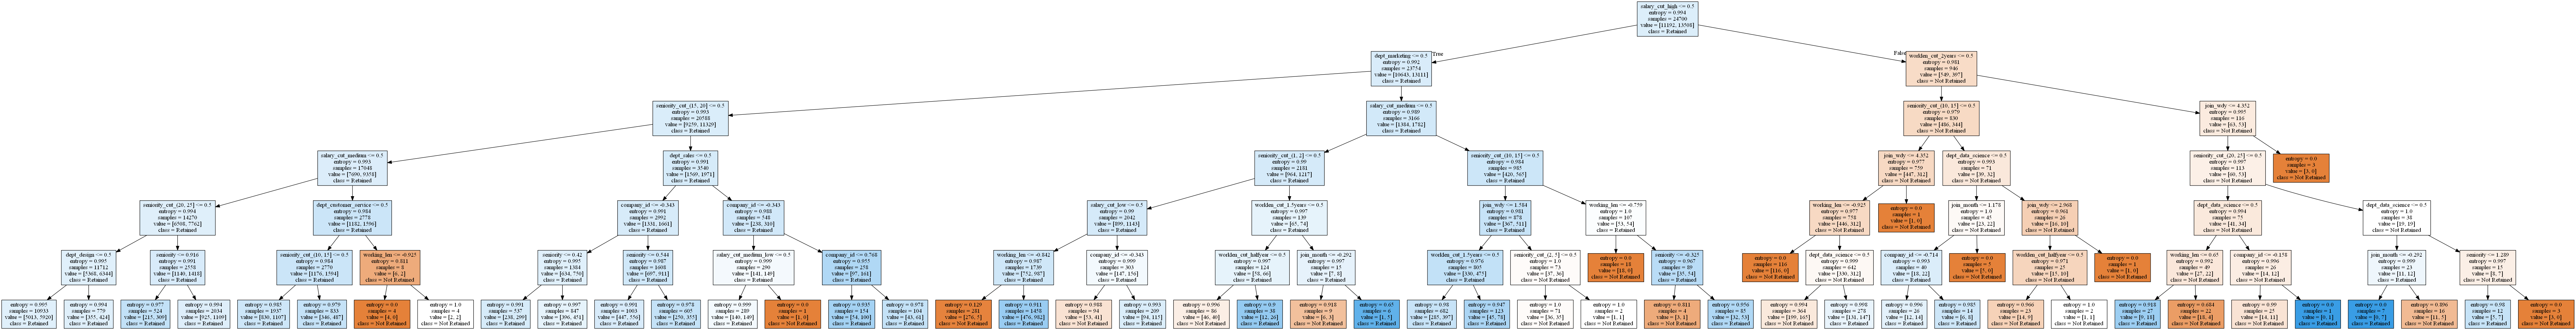

In [57]:
# Packages for rendering our tree.
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.externals.six import StringIO  
dot_data = StringIO()
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=datX_combined.columns,
    class_names=['Not Retained', 'Retained'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

The above decision tree is really informative, there are several things we can learn from the nodes:
- The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
- Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.

## Survivial Analysis Models

In [ ]:
# plot the survival plot by some categorical feature
def plot_kmf_by_feature(dat, feature, save):
    '''
    Input: the dat, and the feature of the dat
    output the kmf plot for that feature in the input dat
    '''
    kmf = KaplanMeierFitter()
    plt.figure(figsize = (12, 6))
    ax = plt.subplot(111)
    feature_unique = dat[feature].unique().tolist()
    for variable in feature_unique:
        # ax.grid(True)
        dat_sub = dat[dat[feature] == variable]
        try:
            kmf.fit(dat_sub['working_len'], 
                    event_observed=dat_sub['onboard'], 
                    label=str(feature) + ":" + str(variable))
        except:
            pass
        kmf.survival_function_.plot(ax=ax)
    plt.xlabel('days since hired')
    plt.ylabel('probability of staying')
    titles = 'Survival analysis of employee retention with working length by ' + str(feature)
    plt.title(titles)
    plt.grid(True)
    if save == True:
        plt.savefig('/output/'+titles+".png")
    else:
        pass

In [ ]:
plot_kmf_by_feature(dat, 'dept', False)

In [ ]:
plot_kmf_by_feature(dat, 'company_id', False)

In [ ]:
plot_kmf_by_feature(dat, 'salary_cut', False)

In [ ]:
# do the Cox survival analysis by considering seniority, salary together
cf = CoxPHFitter()
feats = ['seniority','salary','working_len','onboard']
X = dat[feats]
cf.fit(X, 'working_len', event_col='onboard')
print(cf.print_summary()) # access the results using cf.summary
# use cross validation to get the scores of prediction
scores = k_fold_cross_validation(cf, X, 'working_len', event_col='onboard', k=5)
print(scores,np.mean(scores), np.std(scores))
'''[todo] no idea what this is, I learned it from others blog'''

In [ ]:
# plot the Cox survival anaysis 
plt.figure(figsize = (12, 8))
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
cf.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False,title='Baseline cumulative hazard rate')
cf.baseline_survival_.plot(ax=axes[0,1], legend=False,title='Baseline survival rate')

# Task 3:
If you could add to this data set just one variable that could help explain employee churn, what would that be?

1. Employee promotion during tenure. This can be cheap is the DB of human resources tracks everything.
2. Salary raise by year. This can be cheap is the DB of human resources tracks everything.
3. Non-salary offers given such as stock options. This can be cheap is the DB of human resources tracks everything.
4. The market average of salaries in each department as a reference line. This can be cheap or tricky if using the web-scraping tools to get the external data. Or just buy it from third party consulting firm
5.  Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.